In [8]:
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import Input, Dense, Subtract, Add, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [10]:
# 读取数据
load_path = '../global_data/time_76800x128x9x9/'

trials = np.load(load_path + 'trials.npy')
bases = np.load(load_path + 'bases.npy')
labels = np.load(load_path + 'labels.npy')
print(trials.shape, bases.shape, labels.shape)

(76800, 128, 9, 9) (1280, 128, 9, 9) (1280, 2)


## 数据预处理

In [11]:
# 从 chw 转换为 hwc
print(K.image_data_format())
trials = trials.transpose((0, 2, 3, 1))
bases = bases.transpose((0, 2, 3, 1))
print(trials.shape, bases.shape)

channels_last
(76800, 9, 9, 128) (1280, 9, 9, 128)


In [12]:
# 去基线
trials_de_base = []
for i, base in enumerate(bases):
    trials_de_base.append(trials[i * 60 : (i + 1) * 60] - base)
trials_de_base = np.array(trials_de_base)
trials_de_base = trials_de_base.reshape((-1, 9, 9, 128))
trials_de_base.shape

(76800, 9, 9, 128)

In [13]:
# 离散化标签
labels = np.where(labels >= 5, 1, 0)

# 复制以对齐样本
labels = np.repeat(labels, 60, axis = 0)
print(labels.shape)

(76800, 2)


In [14]:
sample_cnt = trials.shape[0]
# 数据集划分
train_ratio = 0.9
shuffer_list = np.arange(sample_cnt)
np.random.shuffle(shuffer_list)

trials_shuffer = trials[shuffer_list] # trials_de_base
labels = labels[shuffer_list]

x_train = trials_shuffer[:int(train_ratio * sample_cnt)]
y_train = labels[:int(train_ratio * sample_cnt)]
x_test = trials_shuffer[int(train_ratio * sample_cnt):]
y_test = labels[int(train_ratio * sample_cnt):]

In [15]:
SEED = 2022
tf.random.set_seed(SEED)

In [16]:
# 超参设置
max_epoch = 200
batch_size = 32

In [17]:
def cnn2_dens2(shape):
    input_layer = Input(shape=shape, name='input')
    conv1 = Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu', use_bias = True)(input_layer)
    # maxpool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu', use_bias = True)(conv1)
    # maxpool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
#     Dropout(0.25)(maxpool2)

    fl = Flatten()(conv2)
    fc1 = Dense(128, activation = 'relu')(fl)
    dp1 = Dropout(0.5)(fc1)
    fc2 = Dense(64,activation='relu')(dp1)
#     bn = BatchNormalization()(fc1)
    dp2 = Dropout(0.5)(fc2)

    out_layer = Dense(2, activation = 'softmax', name='output')(dp2)

    model = Model(inputs=[input_layer], outputs=[out_layer])

    optimizer = Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    # 可选 categorical_crossentropy

    model.summary()

    os.environ["PATH"] += os.pathsep +'C:/Program Files/Graphviz/bin'
    plot_model(model,'cnn2_dens2.jpg', show_shapes=True)
    
    return model

In [18]:
# z归一化
# 这是正确的通道坐标位置
chan_to_1020={0:[0,3],1:[1,3],2:[2,2],3:[2,0],4:[3,1],5:[3,3],6:[4,2],7:[4,0],8:[5,1],
              9:[5,3],10:[6,2],11:[6,0],12:[7,3],13:[8,3],14:[8,4],15:[6,4],16:[0,5],
              17:[1,5],18:[2,4],19:[2,6],20:[2,8],21:[3,7],22:[3,5],23:[4,4],24:[4,6],
                25:[4,8],26:[5,7],27:[5,5],28:[6,6],29:[6,8],30:[7,5],31:[8,5]}

# 需要归一化的位置
need_norm_pos = np.zeros(shape=(9,9))

for val in chan_to_1020.values():
    need_norm_pos[val[0]][val[1]] = 1
print(need_norm_pos)

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

need_norm_pos = need_norm_pos.reshape(-1)

for i, need_norm in enumerate(need_norm_pos):
    if need_norm == 1:
        mean = np.mean(x_train[:, i * 128 : (i + 1) * 128], axis = 0)
        std = np.std(x_train[:, i * 128 : (i + 1) * 128], axis = 0)
        x_train[:, i * 128 : (i + 1) * 128] -= mean
        x_train[:, i * 128 : (i + 1) * 128] /= std
        x_test[:, i * 128 : (i + 1) * 128] -= mean
        x_test[:, i * 128 : (i + 1) * 128] /= std

x_train = x_train.reshape((-1, 9, 9, 128))
x_test = x_test.reshape((-1, 9, 9, 128))

[[0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]]


In [19]:
# 处理成 tf 的输入格式
y_v_train = to_categorical(y_train[:, 0], 2)
y_a_train = to_categorical(y_train[:, 1], 2)
y__v_test = to_categorical(y_test[:, 0], 2)
y__a_test = to_categorical(y_test[:, 1], 2)

In [20]:
def train_generator(train_path,train_labels,batch):
    while True:
        for i in range(0,len(train_path),batch):
            train_data=train_path[i:i+batch]
            train_label=train_labels[i:i+batch]
            yield ({'input':np.array(train_data)}, {'output':np.array(train_label)})

In [21]:
# 建立模型

model = cnn2_dens2(shape = x_train.shape[1:])

# Train the model
callbacksList = [EarlyStopping(monitor = 'val_acc', patience=10, verbose = 1), # patience当连续多少个epochs时验证集精度不再变好终止训练
                ModelCheckpoint(filepath = f'model/model.h5',monitor='acc',save_best_only=True,)
]

history = model.fit(x=[x_train], y=y_v_train, 
                    validation_data=(x_test, y__v_test), shuffle = True,
                    callbacks = callbacksList,
                    epochs=max_epoch, batch_size = 32, verbose=1)

# 评估
model = load_model('model/model.h5')
score = model.evaluate(x_test, y__v_test, verbose = 1)

"""
Epoch 39/200
2160/2160 [==============================] - 59s 27ms/step - loss: 0.0448 - acc: 0.9878 - val_loss: 0.5709 - val_acc: 0.9161
"""

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9, 9, 128)]       0         
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 128)         147584    
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 10368)             0         
                                                                 
 dense (Dense)               (None, 128)               1327232   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

'\nEpoch 39/200\n2160/2160 [==============================] - 59s 27ms/step - loss: 0.0448 - acc: 0.9878 - val_loss: 0.5709 - val_acc: 0.9161\n'

In [ ]:
# # 建立模型

# model = cnn2_dens2(shape = x_train.shape[1:])

# # Train the model
# callbacksList = [EarlyStopping(monitor = 'val_acc', patience=10, verbose = 1), # patience当连续多少个epochs时验证集精度不再变好终止训练
#                 ModelCheckpoint(filepath = f'model/model.h5',monitor='acc',save_best_only=True,)
# ]

# history = model.fit(x=[x_train], y=y_v_train, 
#                     validation_data=(x_test, y__v_test), shuffle = True,
#                     callbacks = callbacksList,
#                     epochs=max_epoch, batch_size = 32, verbose=1)

# # 评估
# model = load_model('model/model.h5')
# score = model.evaluate(x_test, y__v_test, verbose = 1)

# """ 这个是用师弟的10-20系统方式算的准确率
# Epoch 39/200
# 2160/2160 [==============================] - 59s 27ms/step - loss: 0.0448 - acc: 0.9878 - val_loss: 0.5709 - val_acc: 0.9161
# """

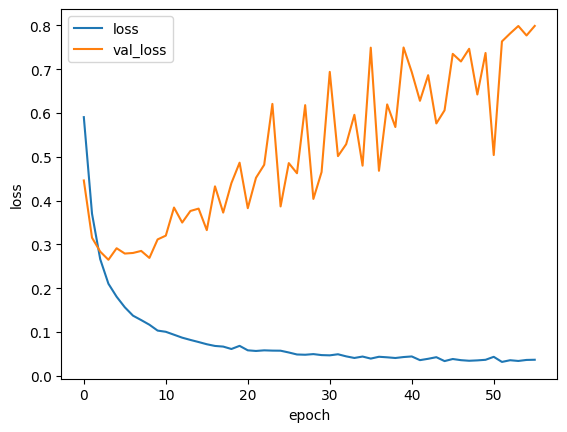

In [32]:
# 查看训练曲线
plt.plot(history.epoch,history.history.get('loss'),label="loss")
plt.plot(history.epoch,history.history.get('val_loss'),label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()


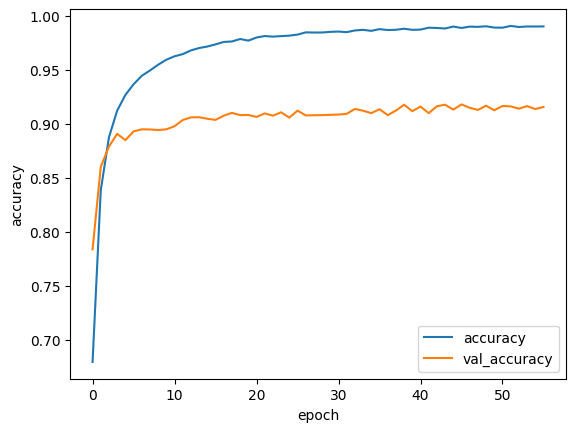

In [33]:
plt.plot(history.epoch,history.history.get('acc'),label="accuracy")
plt.plot(history.epoch,history.history.get('val_acc'),label="val_accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()


In [ ]:
# # 评估
# score = model.evaluate(x_test, y_test, verbose = 0) 
# print('Test loss:', score[0]) 
# print('Test accuracy:', score[1])

# # 预测
# pred = model.predict(x_test) 
# pred = np.argmax(pred, axis = 1)[:5] 
# label = np.argmax(y_test,axis = 1)[:5] 
# print(pred) 
# print(label)
